# Molecular Informatics Project
### Created by: Karla Vela 
### Created on 10/25/24

<span style="color:red; font-size:35px; font-weight:bold">Step 1: Import libraries  </span>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
from torch_geometric.utils import to_networkx
from torch.utils.tensorboard import SummaryWriter
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.transforms import Compose
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree
import numpy as np

<span style="color:red; font-size:35px; font-weight:bold">Step 2: Import data - DisGeNET disease associations  </span>

>#### - First, import the processed DisGeNET data that was wrangled and cleaned through R. This final data set keeps data with a confidence score of above .1 and MONDO disease identifiers have been mapped to the UMLS disease identifiers that are used in DisGeNET. This data set also includes the propagated genes. 

>#### - Second, import the raw BioGRID data. This will be used to add more connections between our genes in the bipartite graph and the interaction scores will be used as a node features for the gene nodes as well.

<span style="color:teal; font-size:25px; font-weight:bold">Get DisGeNET data </span>


In [2]:
SEED = 42

# read in disgnet disease gene associations
disgenet_raw = pd.read_csv('../data/processed/propagated_disgenet_genes.tsv', delimiter= '\t')
disgenet_raw.head(15)

,gene_id,gene_name,mondo_id,mondo_term
0,2,A2M,MONDO:0004975,Alzheimer disease
1,2,A2M,MONDO:0021063,malignant colon neoplasm
2,2,A2M,MONDO:0005401,colonic neoplasm
3,2,A2M,MONDO:0002050,depressive disorder
4,2,A2M,MONDO:0005376,membranous glomerulonephritis
5,2,A2M,MONDO:0010200,Wilson disease
6,2,A2M,MONDO:0005155,cirrhosis of liver
7,2,A2M,MONDO:0002691,liver cancer
8,2,A2M,MONDO:0005377,nephrotic syndrome
9,2,A2M,MONDO:0000940,trypanosomiasis


> ####  Since this is a propagated dataset, the broader term will have thousands of genes that come from the lower level term. For instance, in the dataframe below we can see that a broad term like cancer has more than 5,000 genes and it also doesn't tell us much about this particular disease because there are many types of cancers. This is why this disease id has so many genes because it includes the genes of all the types of cancers that belong under this term like lung cancer, kidney cancer, etc. Thus, adding a threshold to take out these braod terms can be done by keeping only diseases with a certain amount of genes. 

In [40]:
# need to get rid of broader disease terms like respiratory disease, human disease, genetic diseases etc
# Count unique gene IDs for each MONDO term
gene_counts = disgenet_raw.groupby(['mondo_id', 'mondo_term'])['gene_id'].nunique().reset_index()
gene_count_df = gene_counts.rename(columns={'gene_id': 'gene_count'})


In [41]:
gene_count_df.sort_values(by='gene_count', ascending=False)

,mondo_id,mondo_term,gene_count
726,MONDO:0005070,neoplasm,6556
727,MONDO:0005071,nervous system disorder,5569
690,MONDO:0004992,cancer,5522
362,MONDO:0002602,central nervous system disorder,4317
263,MONDO:0002081,musculoskeletal system disorder,3819
...,...,...,...
3557,MONDO:0012891,pontocerebellar hypoplasia type 2C,1
3558,MONDO:0012892,"bone fragility with contractures, arterial rup...",1
3559,MONDO:0012895,torsion dystonia 17,1
3562,MONDO:0012900,"cardiomyopathy, familial restrictive, 3",1


>#### You can look at the full gene_count_df clickin on the jupter tab in the terminal panel. Look for the data frame in the list of variables and click on it. There you can sort the gene count value in descending order. The most specific term is seen around the 1500 gene count area thus we can now filter the gene_count_df to contain diseases with a gene ount of 1500 or less. Then the gene_count column is taken out. As seen in the new data frame there are more specific disorders but there are still some broader terms left behind. More filtering can be done but we do not want to greatly reduce the amount of data because most neural networks and machine learning models do better with large data sets.

In [ ]:
# Keep only terms with 1500 or fewer genes
filtered_gene_counts = gene_count_df[gene_count_df['gene_count'] <= 1500]
# Filter the original data to include only the selected MONDO terms based on the gene count threshold
new_disgenet_df = disgenet_raw[disgenet_raw['mondo_id'].isin(filtered_gene_counts['mondo_id'])]
new_disgenet_df

,gene_id,gene_name,mondo_id,mondo_term
0,2,A2M,MONDO:0004975,Alzheimer disease
1,2,A2M,MONDO:0021063,malignant colon neoplasm
2,2,A2M,MONDO:0005401,colonic neoplasm
3,2,A2M,MONDO:0002050,depressive disorder
4,2,A2M,MONDO:0005376,membranous glomerulonephritis
...,...,...,...,...
235333,106783499,OPA8,MONDO:0002135,optic nerve disorder
235334,106783499,OPA8,MONDO:0043878,hereditary optic atrophy
235335,106783499,OPA8,MONDO:0020250,autosomal dominant optic atrophy
235336,107305681,DHS6S1,MONDO:0005283,retinal disorder


>#### Now we just want to look at the amount of genes that are associated with TB to get an idea of how many we have to start with. There are 106.

In [5]:
# get genes associated to TB
disgenet_tb_df = new_disgenet_df[new_disgenet_df['mondo_id'] == 'MONDO:0018076']
tb_pos_disgenes = [str(gene) for gene in set(disgenet_tb_df['gene_id'].tolist())]
disgenet_tb_df


,gene_id,gene_name,mondo_id,mondo_term
34,10,NAT2,MONDO:0018076,tuberculosis
664,100,ADA,MONDO:0018076,tuberculosis
1206,181,AGRP,MONDO:0018076,tuberculosis
6472,820,CAMP,MONDO:0018076,tuberculosis
6857,847,CAT,MONDO:0018076,tuberculosis
...,...,...,...,...
221158,59067,IL21,MONDO:0018076,tuberculosis
225666,1437,CSF2,MONDO:0018076,tuberculosis
225667,3918,LAMC2,MONDO:0018076,tuberculosis
225668,27241,BBS9,MONDO:0018076,tuberculosis


In [6]:
print("Number of TB genes:", len(tb_pos_disgenes))

Number of TB genes: 106


<span style="color:teal; font-size:25px; font-weight:bold">Load BioGRID and get connected network </span>


In [7]:
# read in network data file
biogrid_raw = pd.read_csv("../data/bigdatasets/biogrid_network.txt", sep='\t') 

#take a look
biogrid_raw.head()

,#ID Interactor A,ID Interactor B,Alt IDs Interactor A,Alt IDs Interactor B,Aliases Interactor A,Aliases Interactor B,Interaction Detection Method,Publication 1st Author,Publication Identifiers,Taxid Interactor A,Taxid Interactor B,Interaction Types,Source Database,Interaction Identifiers,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,biogrid:112315|entrez gene/locuslink:MAP2K4|un...,biogrid:108607|entrez gene/locuslink:FLNC|unip...,entrez gene/locuslink:JNKK(gene name synonym)|...,entrez gene/locuslink:ABP-280(gene name synony...,"psi-mi:""MI:0018""(two hybrid)",Marti A (1997),pubmed:9006895,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:103,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,biogrid:124185|entrez gene/locuslink:MYPN|unip...,biogrid:106603|entrez gene/locuslink:ACTN2|uni...,entrez gene/locuslink:CMD1DD(gene name synonym...,entrez gene/locuslink:CMD1AA(gene name synonym),"psi-mi:""MI:0018""(two hybrid)",Bang ML (2001),pubmed:11309420,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:117,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,biogrid:106605|entrez gene/locuslink:ACVR1|uni...,biogrid:108625|entrez gene/locuslink:FNTA|unip...,entrez gene/locuslink:ACTRI(gene name synonym)...,entrez gene/locuslink:FPTA(gene name synonym)|...,"psi-mi:""MI:0018""(two hybrid)",Wang T (1996),pubmed:8599089,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:183,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,biogrid:108894|entrez gene/locuslink:GATA2|uni...,biogrid:111384|entrez gene/locuslink:PML|unipr...,entrez gene/locuslink:DCML(gene name synonym)|...,entrez gene/locuslink:MYL(gene name synonym)|e...,"psi-mi:""MI:0018""(two hybrid)",Tsuzuki S (2000),pubmed:10938104,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:278,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,biogrid:112038|entrez gene/locuslink:RPA2|entr...,biogrid:112651|entrez gene/locuslink:STAT3|uni...,entrez gene/locuslink:REPA2(gene name synonym)...,entrez gene/locuslink:ADMIO(gene name synonym)...,"psi-mi:""MI:0018""(two hybrid)",Kim J (2000),pubmed:10875894,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:418,-


> #### Raw data is often messy data and requires a lot of cleaning and processing steps. To start, this PPI network has other species interaction data as well so we want to get rid of these data points and get rid of any columns that are not relevant for this application.

In [8]:
# biogrid has proteins for other species. I want only the human proteins so filter these out.
human_biogrid_raw =biogrid_raw[(biogrid_raw['Taxid Interactor A'] == "taxid:9606") & (biogrid_raw['Taxid Interactor B'] == "taxid:9606")]

In [9]:
# get rid of umwanted columns
columns_to_drop= ['Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B','Interaction Types',
 'Source Database',
 'Interaction Identifiers']
human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)

human_biogrid_raw.head()
print("Shape of dataframe", human_biogrid_raw.shape)

Shape of dataframe (1131384, 3)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/1794002502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)


>#### The confidence values have the following string in front of the numerical score "score". Thus we want to get rid of this string and only keep the numerical aspect and also ensure that the numerical part is defined as a float type. Machine learning models and neural networks only work best with numbers thus we need to make sure our data is in int or float data types. There are also NAs so these have to be omitted and delete the string parts out of the interactor a and interactor b columns. We want to only keep the gene id which is the entrez gene id.

In [10]:
# format values in the confidence values so only the numeric part is kept

#checking for na scores. NA scores are represented with '-'
look_at_score =human_biogrid_raw["Confidence Values"].unique()
# for score in look_at_score:
#     print(score)

#remove the score part
human_biogrid_raw.loc[:,'Confidence Values'] = human_biogrid_raw['Confidence Values'].str.replace('score:', '') 
    
print(human_biogrid_raw.dtypes)
#get rid of any rows that have '-' in the confidence value
filtered_biogrid = human_biogrid_raw[human_biogrid_raw['Confidence Values'] != "-"]

# ensure correct data type for the confidence scores.
filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)
print("After changing dat types \n", filtered_biogrid.dtypes)

# now doing the same for the genes in interactor a and b columns
filtered_biogrid.loc[:, '#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].str.split(':').str[-1]

filtered_biogrid.loc[:, 'ID Interactor B'] = filtered_biogrid['ID Interactor B'].str.split(':').str[-1]

# check data type of columns
print("Check data type\n", filtered_biogrid.dtypes)

#ID Interactor A     object
ID Interactor B      object
Confidence Values    object
dtype: object
After changing dat types 
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/1519717752.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)


Check data type
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


In [ ]:
# check data frame to ensure these changes are correct and give us the desired df
filtered_biogrid.head()

,#ID Interactor A,ID Interactor B,Confidence Values
121446,10421,23020,1.000
121447,10755,4646,0.952
121448,1974,1981,0.931
121449,10421,10594,0.919
121450,382,10128,0.909


>#### Next we want to look at the range of confidence values. As you can see the range is too broad which can lead to problems in training. When the range is broad the machine learning models or neural net can emphasize more importance on features/inputs that have a larger magnitude which creates bias. It can also make it difficult to optimize your model which leads to poor performance/accuracy. So to prevent this, the confidence values have to be standardized.

In [12]:
# check range of confidence values
max_conf_values = filtered_biogrid['Confidence Values'].max()
min_conf_values = filtered_biogrid['Confidence Values'].min()

print(f"Max confidence value { max_conf_values} and min confidence value {min_conf_values}")

Max confidence value 52530.0 and min confidence value -24.621


In [13]:
# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
# drop confidence values column and only keep the standardized values
filtered_biogrid.drop(columns='Confidence Values', inplace=True)

filtered_biogrid.head(20)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/4269995461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/4269995461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid.drop(columns='Confidence Values', inplace=True)


,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
121451,7532,3799,-0.071236
121452,9337,23019,-0.071239
121453,55723,79711,-0.071568
121454,28988,8924,-0.071603
121455,9410,10594,-0.071612


<span style="color:red; font-size:35px; font-weight:bold">Step 3: Get your node features </span>

Code adapted from the following [Collab- CS224W Project Disease Gene Interactions.ipynb](https://colab.research.google.com/drive/1Jv0GrF11jcbhiV7dK-RhxKCv_GLVvTls?usp=sharing)

>#### Node features are important in GAEs because they help the model encode meaningul representations of nodes and learning the structure of the graph effectively. In this case, I decided to add the confidence values of all the genes in the BioGRID network. So if gene a had 5 interactions with different genes then these 5 confidence scores are added. This could be helpful because ideally the more interactions the gene has, the more it is connected within the network indicating it may play an important role in specific biologically processes. The downside is that those with little to no interactions may not be emphasized enough in the encoding section which leads to prefering the more connected genes. This is one downside in using PPI networks because not all genes/proteins in the network are well characterized but this is why doing this work is also important because there is a chance these models can help create new connections for these less characterized genes. These node features will be added to the gene nodes of the GAE.

In [14]:
gene_features = {}

# add the confidence values for each gene
for _, row in filtered_biogrid.iterrows():
    gene_features.setdefault(row['#ID Interactor A'], 0)
    gene_features.setdefault(row['ID Interactor B'], 0)
    gene_features[row['#ID Interactor A']] += row['Standardized_confidence_values']
    gene_features[row['ID Interactor B']] += row['Standardized_confidence_values']

# convert the dictionary to a df
gene_features_df = pd.DataFrame.from_dict(gene_features, orient='index', columns=['feature'])
gene_features_df.reset_index(inplace=True)
gene_features_df.columns = ['gene_id', 'feature']

# ensure gene_id in new_disgenet_df is string type
new_disgenet_df['gene_id'] = new_disgenet_df['gene_id'].astype(str)

# ensure gene_id in gene_features_df is string type
gene_features_df['gene_id'] = gene_features_df['gene_id'].astype(str)

# merge the features with the disease-gene data
disgenet_with_features = new_disgenet_df.merge(gene_features_df, how='left', on='gene_id')

# fill NaN values with 0 
disgenet_with_features['feature'].fillna(0, inplace=True)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/2744078329.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_disgenet_df['gene_id'] = new_disgenet_df['gene_id'].astype(str)


In [ ]:
# visualize the df
disgenet_with_features

,gene_id,gene_name,mondo_id,mondo_term,feature
0,2,A2M,MONDO:0004975,Alzheimer disease,-3.774064
1,2,A2M,MONDO:0021063,malignant colon neoplasm,-3.774064
2,2,A2M,MONDO:0005401,colonic neoplasm,-3.774064
3,2,A2M,MONDO:0002050,depressive disorder,-3.774064
4,2,A2M,MONDO:0005376,membranous glomerulonephritis,-3.774064
...,...,...,...,...,...
160765,106783499,OPA8,MONDO:0002135,optic nerve disorder,0.000000
160766,106783499,OPA8,MONDO:0043878,hereditary optic atrophy,0.000000
160767,106783499,OPA8,MONDO:0020250,autosomal dominant optic atrophy,0.000000
160768,107305681,DHS6S1,MONDO:0005283,retinal disorder,0.000000


<span style="color:red; font-size:35px; font-weight:bold">Step 4: Create Pytorch data object </span>

>#### To be able to train the GAE, a pytorch data object is needed which is the core data structure used to represent graphs and in this case it will be a bipartite graph. This will contain your node features, edge index, edge features, labels, and other metadata that you want to include. Below are 3 functinos that will help create the pytorch data object. For this first GAE a pytorch data object containing disease and genes will be created. There will  be two sets of nodes: gene and disease nodes.

1. **node_mapping** - creates a mapping dictionary to keep track of the features/inputs. In this case we will have a mapping that will tell us what disease is what node and what gene is what node. 
2. **edge_list** - creates an edge list which tells us what genes are connected to what diseases. 
3. **get_data_with_features** - creates the actual pytorch data object using the disgenet_with_features data frame. 

In [ ]:
# construct the pytroch data object to train models
def node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

In [ ]:
def edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

In [ ]:

def get_data_with_features(disgenet_with_features, num_features):
    dis_col, gene_col = "mondo_id", "gene_id"
    
    # get the node index mappings
    map_dis_nodes = node_mapping(disgenet_with_features, dis_col)
    map_gene_nodes = node_mapping(disgenet_with_features, gene_col)
    
    # get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, dis_col, map_dis_nodes, gene_col, map_gene_nodes)
    
    # add the reverse index to make it an undirected graph
    reverse_edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, dis_col, map_dis_nodes)
    
    # initialize the data object
    data = Data()
    data.num_nodes = len(map_dis_nodes) + len(map_gene_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # initialize disease features as ones
    dis_features = torch.ones((len(map_dis_nodes), num_features), dtype=torch.float32)
    
    # initialize gene features using the merged df
    gene_features_values = disgenet_with_features.drop_duplicates(subset='gene_id').set_index('gene_id')[['feature']].reindex(map_gene_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_gene_nodes, map_dis_nodes

In [ ]:
# declare number of features
num_features = 1

# call function that will create the pytorch data object
disgenet_torch_data, gene_mappings, disease_mappings = get_data_with_features(disgenet_with_features, num_features)


In [ ]:
# take a look at what the pytorch data object looks like. x= how many features there are and how many are in that row. Ex. there are 18140 feautre in total but each node has 1 feature (1 confidence score value).
print(disgenet_torch_data)
print("Number of genes: ", len(gene_mappings))
print("Number of diseases: ", len(disease_mappings))

Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Number of genes:  11583
Number of diseases:  6557


In [42]:
# bring up dataframe for reference
disgenet_with_features

,gene_id,gene_name,mondo_id,mondo_term,feature
0,2,A2M,MONDO:0004975,Alzheimer disease,-3.774064
1,2,A2M,MONDO:0021063,malignant colon neoplasm,-3.774064
2,2,A2M,MONDO:0005401,colonic neoplasm,-3.774064
3,2,A2M,MONDO:0002050,depressive disorder,-3.774064
4,2,A2M,MONDO:0005376,membranous glomerulonephritis,-3.774064
...,...,...,...,...,...
160765,106783499,OPA8,MONDO:0002135,optic nerve disorder,0.000000
160766,106783499,OPA8,MONDO:0043878,hereditary optic atrophy,0.000000
160767,106783499,OPA8,MONDO:0020250,autosomal dominant optic atrophy,0.000000
160768,107305681,DHS6S1,MONDO:0005283,retinal disorder,0.000000


In [ ]:
# look at the mapping dictionaries to see where each MONDO id is and their corresponding annotated gene. For instance MONDO:0004975 is in disease node 0 and it's annotated gene 2 is also in gene node 0.
# above you can see that the dataframe confirms the mappings are correct.
print(f"gene mappings: {gene_mappings}")
print(f"disease mappings: {disease_mappings}")

gene mappings: {'2': 0, '9': 1, '10': 2, '12': 3, '15': 4, '16': 5, '18': 6, '19': 7, '20': 8, '21': 9, '22': 10, '23': 11, '24': 12, '25': 13, '26': 14, '27': 15, '28': 16, '29': 17, '31': 18, '32': 19, '33': 20, '34': 21, '35': 22, '36': 23, '37': 24, '38': 25, '39': 26, '40': 27, '41': 28, '43': 29, '47': 30, '48': 31, '49': 32, '50': 33, '51': 34, '53': 35, '54': 36, '55': 37, '58': 38, '59': 39, '60': 40, '70': 41, '71': 42, '72': 43, '81': 44, '86': 45, '87': 46, '88': 47, '90': 48, '91': 49, '92': 50, '93': 51, '94': 52, '95': 53, '100': 54, '102': 55, '103': 56, '104': 57, '105': 58, '107': 59, '108': 60, '109': 61, '111': 62, '112': 63, '113': 64, '114': 65, '115': 66, '116': 67, '117': 68, '118': 69, '119': 70, '120': 71, '123': 72, '125': 73, '126': 74, '127': 75, '128': 76, '131': 77, '132': 78, '133': 79, '134': 80, '135': 81, '140': 82, '142': 83, '143': 84, '146': 85, '147': 86, '148': 87, '150': 88, '151': 89, '152': 90, '153': 91, '154': 92, '155': 93, '156': 94, '157'

In [43]:
# save the pytorch data object to keep for future reference and so you don't have to run the whole script again.
torch.save(disgenet_torch_data, '../data/processed/disgenet_torch_data.pt')
new_disgenet_torch_data = torch.load('../data/processed/disgenet_torch_data.pt')
print(disgenet_torch_data)
print(new_disgenet_torch_data)

Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])
Data(num_nodes=18140, edge_index=[2, 321540], x=[18140, 1])


<span style="color:red; font-size:35px; font-weight:bold">Step 5: Visualize the bipartite graph</span>

>#### It's nice to visualize what the graph can look like so you can understand whiat the GAE will train on. REMEMBER this is only a veeeeeeery small section of the entire pytorch data object that was developed. If the whole thing were to be graphed two things would happen. 1) It would take forever for the code chunk to execute because the pytorch data object is masive. It has 18,000+ nodes and more than 300,000 edges to connect the nodes. This takes a lot of time to graph and 2) if it does execute the plot would look like a huge blob becase of the same issue that was addressed in #1; there's just too much to graph and it all clusters around each other.

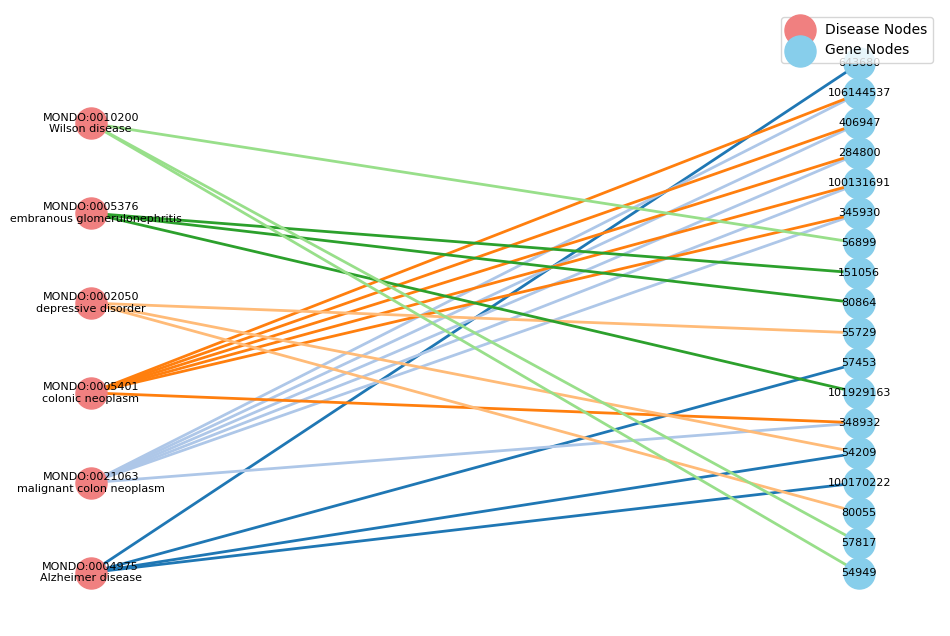

In [ ]:
# Convert the PyTorch Geometric Data to a NetworkX graph and remove disease-to-disease edges
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Filter out disease-to-disease edges (if not already done in the previous step)
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes based on disease_mappings
disease_node_indices = list(disease_mappings.values())[:6]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Create a subgraph with the selected disease and limited gene nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes))

# Create a dictionary for MONDO ID to disease name mapping
mondo_to_name = dict(zip(disgenet_raw['mondo_id'], disgenet_raw['mondo_term']))

# Create a dictionary to label nodes with MONDO IDs, disease names, and Entrez Gene IDs
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Set fixed positions for a bipartite layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:red; font-size:35px; font-weight:bold">Step 6: Add BioGrid network gene connections to graph </span>

> #### Since I want to add as many connections as possible, adding PPI network connections from BioGRID can add more relevant information to the graph. This will add links between genes that interact with another which can be useful because genes that are highly connected to one another often are involved in biological process. This means they have similar functions and can also help create new connections during training for genes that may not be as well connected.


In [ ]:
# Filter BioGRID edges based on gene IDs in `new_disgenet_torch_data`
gene_indices = set(gene_mappings.values())  # assuming `gene_mappings` is available

# Step 1: Create an edge list from the BioGRID DataFrame
biogrid_edges = []
for _, row in filtered_biogrid.iterrows():
    gene_a = row['#ID Interactor A']
    gene_b = row['ID Interactor B']
    
    # Check if both genes are in `new_disgenet_torch_data`
    if gene_a in gene_mappings and gene_b in gene_mappings:
        node_a = gene_mappings[gene_a]  # Get the index in `new_disgenet_torch_data`
        node_b = gene_mappings[gene_b]
        biogrid_edges.append([node_a, node_b])

# Step 2: Convert to tensor and add to existing edge_index
biogrid_edges = torch.tensor(biogrid_edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

# Combine with existing edges in `new_disgenet_torch_data`
new_edge_index = torch.cat([new_disgenet_torch_data.edge_index, biogrid_edges], dim=1)

# Step 3: Update `disgenet_torch_data` with the new edges
new_disgenet_torch_data.edge_index = new_edge_index



/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/3655981336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].astype(int)
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_92152/3655981336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['ID Interactor B'] = filtered_biogrid['ID Interactor B'].astype(int)


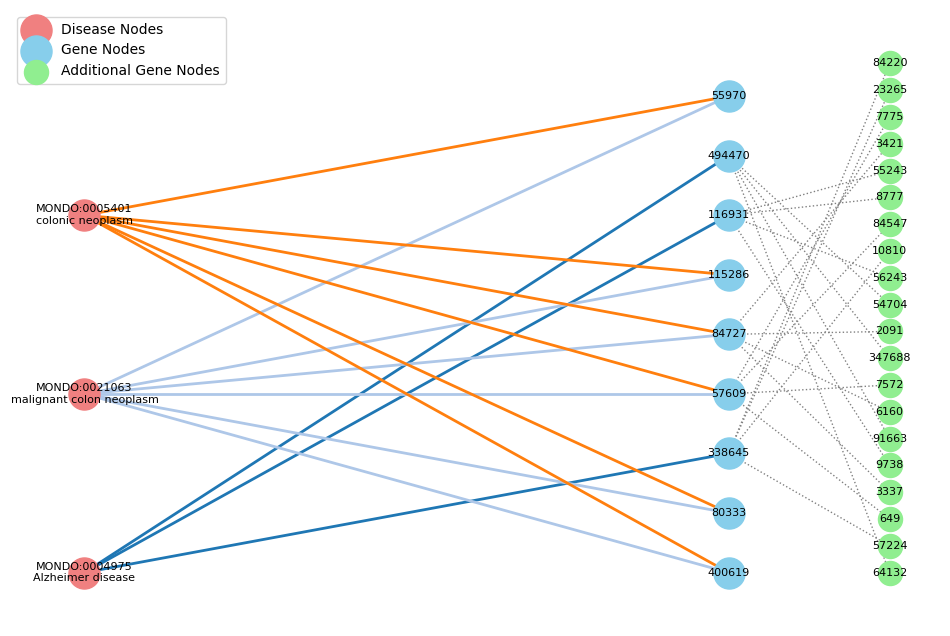

In [24]:

filtered_biogrid['#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].astype(int)
filtered_biogrid['ID Interactor B'] = filtered_biogrid['ID Interactor B'].astype(int)

# Make sure gene_mappings keys and values are also integers for consistency
gene_mappings = {int(k): int(v) for k, v in gene_mappings.items()}

# Now proceed with identifying additional genes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])


# Convert the PyTorch Geometric Data to a NetworkX graph
G = to_networkx(new_disgenet_torch_data, to_undirected=True)

# Remove disease-to-disease edges if necessary
disease_nodes = set(disease_mappings.values())
disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
G.remove_edges_from(disease_to_disease_edges)

# Select the first 6 disease nodes
disease_node_indices = list(disease_mappings.values())[:3]

# Limit the number of gene nodes to display per disease node
gene_limit_per_disease = 3
connected_gene_nodes = set()
for disease_node in disease_node_indices:
    neighbors = list(G.neighbors(disease_node))
    gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
    sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
    connected_gene_nodes.update(sampled_genes)

# Identify additional gene nodes connected to blue gene nodes
additional_gene_nodes = set()
additional_gene_edges = []
for blue_gene_node in connected_gene_nodes:
    # Filter biogrid data to find genes connected to each blue gene node
    related_genes = filtered_biogrid[(filtered_biogrid['#ID Interactor A'] == blue_gene_node) | 
                                     (filtered_biogrid['ID Interactor B'] == blue_gene_node)]
    additional_genes = set(related_genes['#ID Interactor A']).union(set(related_genes['ID Interactor B']))
    additional_genes.discard(blue_gene_node)  # Remove the blue node itself from the list
    sampled_additional_genes = random.sample(list(additional_genes), min(4, len(additional_genes)))
    
    # Add to additional gene nodes and edges
    additional_gene_nodes.update(sampled_additional_genes)
    additional_gene_edges.extend([(blue_gene_node, gene) for gene in sampled_additional_genes])

# Create a subgraph with the selected nodes
subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes) + list(additional_gene_nodes))

# Create a dictionary for node labels
labels = {}
for disease_id, node in disease_mappings.items():
    if node in disease_node_indices:
        disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
        labels[node] = f"{disease_id}\n{disease_name}"

# Label existing blue gene nodes
for gene_id, node in gene_mappings.items():
    if node in connected_gene_nodes:
        labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

# Label additional gene nodes
for gene in additional_gene_nodes:
    # If gene ID is not already labeled, add it to labels
    labels[gene] = str(gene)  # Use the gene ID itself as the label


# Set fixed positions for a clearer layout
pos = {}
# Disease nodes on the left
for i, node in enumerate(disease_node_indices):
    pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

# Blue gene nodes on the right
for i, node in enumerate(connected_gene_nodes):
    pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

# Additional gene nodes further to the right
for i, node in enumerate(additional_gene_nodes):
    pos[node] = (1.5, i * (2 / len(additional_gene_nodes)) - 1)

# Plotting
plt.figure(figsize=(12, 8))

# Draw disease and gene nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color="lightcoral", label="Disease Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color="skyblue", label="Gene Nodes", node_size=500)
nx.draw_networkx_nodes(subgraph, pos, nodelist=list(additional_gene_nodes), node_color="lightgreen", label="Additional Gene Nodes", node_size=300)

# Color each disease's edges uniquely
colors = plt.cm.tab20.colors
for idx, disease_node in enumerate(disease_node_indices):
    disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
    nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

# Draw edges between blue gene nodes and additional gene nodes
nx.draw_networkx_edges(subgraph, pos, edgelist=additional_gene_edges, edge_color="grey", width=1, style="dotted")

# Add labels with MONDO IDs, disease names, and Entrez IDs
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Add legend and display
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()


<span style="color:red; font-size:35px; font-weight:bold">Step 7: Split data for training, testing and validation </span>

#### To train a neural net and a machine learning model you have to split your dataset into training, testing and validation. A usual rule of thumb of how to split it is 80 for training and 20% for testing (out of the testing you can do 5-10% for validation). The reason for each split is explained below but overall it is so the models are trained well and they are generalizable. Since a GNN approach is being used there are different ways you can split your training, test, and validation sets. You can either separate the edges or the nodes. In this case we are going to have the model learn from the connection between nodes which means we are splitting the edges. The edges are being split because GAEs are often used for link predictions (predicting what links should exist between different sets of nodes) and in this application it makes sense that we want to see what connections should exist between nodes based on the entire structure of the graph.

>1. **Training set** - used to train the model by updating its parameters which are values that the model learns during trainnig to make predictions and can make it possible for the model to understand the patterns that exist within the data. It's like the knobs used to minimize the error and also provide the "memory" of the model so it knows what it learned in the past and can do its best to recall it when it sees new data. **BIG PICTURE: MINIMIZE ERROR AND LEARN THE PATTERNS**


>2. **Validation set** - used during training to evaluate the model's performance on data that it hasn't seen yet. This is usefull to detect overfitting which is when the model learns TOOOO well that it can even pick up noise or just learns too many details which results in performing well in training but struggles with unseen data. This means the model is no longer generalizable. It's like memorizing all the answers to the practice test but then when you get the actual test you no longer have the same questions so you fail because you didn't understand the underlying concepts. 


>3. **Test set** - used for training and validation to assess the final performance of the model on completely unseen data. This is the true test of the model because it would reflect how it would do in a real-world setting. Also, since it hasn't seen this data then we can assume that it provides an unbiased evaulation of the model's performance.



In [25]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

train_set, val_set, test_set = transform(new_disgenet_torch_data)
print("Training set: \n", train_set)
print("Validation set: \n", val_set)
print("Test set: \n", test_set)

cpu
Training set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[195664], pos_edge_label_index=[2, 195664], neg_edge_label=[195664], neg_edge_label_index=[2, 195664])
Validation set: 
 Data(num_nodes=18140, edge_index=[2, 391328], x=[18140, 1], pos_edge_label=[12228], pos_edge_label_index=[2, 12228], neg_edge_label=[12228], neg_edge_label_index=[2, 12228])
Test set: 
 Data(num_nodes=18140, edge_index=[2, 415784], x=[18140, 1], pos_edge_label=[36686], pos_edge_label_index=[2, 36686], neg_edge_label=[36686], neg_edge_label_index=[2, 36686])


<span style="color:red; font-size:35px; font-weight:bold">Step 8: Train, Test and Validate the first GAE (disease and gene graph)</span>

> #### To begin we need a way to visualize the results so two functions were made and are explained below.

#### 1. **plot_roc_curve** - function plots the ROC curve which is a way to measure how good a model is at making predicitons. It shows the balance between true positives and false positives.
#### 2. **plot_training_stats** - function plots the training and test stats. It specifically plots the AP (average precision) and AUC (area under the curve).
#####   * *AP* - is a way to measure how well a model balances precision (being correct) and recall (finding all the correct items) across different confidence levels.
#####   * *AUC*- is a way to measure how well a model can tell the difference between two classes, like "spam" and "not spam" or in this case "an edge exists" and "an edge does NOT exist"

In [ ]:
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_roc_curve(title, model, data):
    model.eval()

    x = data.x
    z = model.encode(x, data.edge_index)

    pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
    neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    preds = preds.detach().cpu().numpy()

    labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
    labels = labels.detach().cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    auc= tpr - fpr
    ix = np.argmax(auc)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.roc_auc_score(labels, preds)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--') 
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.title(title)

    # create a filename based on the title
    sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
    filename = f"../data/figures/{sanitized_title}_roc_curve.png"

    # save the plot
    #plt.savefig(filename)

    plt.show()

    plt.close()


In [ ]:
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap, save_path=None):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  
  # Create a filename based on the title
  sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
  filename = f"../data/figures/{sanitized_title}_result_stats.png"

  # Save the plot
  #plt.savefig(filename)

  # Show the plot
  plt.show()

  # Close the plot to avoid displaying it multiple times in interactive environments
  plt.close(fig)
  

> #### The next two functions are used to get the final predictions of the test set. As part of the workflow they are designed to compute similarity scores between the nodes in the graph and all possible edges are ranked based on the similarity scores. An explanation of each function can be found below.

##### 1. **get_edge_dot_products**: computes the dot products between the embeddings of two nodes (the disease and gene nodes) to quantify their similairty. A similarity score helps determine which nodes are most alike based on their embeddings. In this case it is looking at what disease node is most similar to a gene node. Nodes with high similarity scores are close to another which mean they share similar properties or roles in the graph, therefore, there's a high likelihood that an edge exists between them.
##### 2. **get_ranked_edges**: function ranks all possible edges between the two groups of nodes based on the similarity scores/edge dot products. This is done to prioritize potential relationships between nodes based on the similarity nodes.

In [ ]:
unique_dis = len(disgenet_raw['mondo_id'].unique())
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb

# following two functions help get the results of the predictions after testing is done. 
def get_edge_dot_products(data, model, num_dz_nodes=unique_dis):

  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=unique_dis):

  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


In [29]:
# define the GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

<span style="color:red; font-size:35px; font-weight:bold">Step 9: Run the GAE</span>

#### Now that the main functions that create the main parts of the workflow (performance metrics, GAE architecture, prediction output) then the  hyperparameter settings can be declared for the model. 
#####    * *Hyperparamters*- are the settings you can choose before training a machine larning model or neural net. These are NOT learned; they are manually set.
#### These hyperparameters are then given to the functions in charge of creating the actual GAE model. An optimizer is also declared which helps the model improve its predictions by adjusting the parameters (the settings that are automatically optimized during training). The main purpose of this step is to update these parameters so it minimizes the error/loss. 

In [ ]:
# initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 500
output_dim = 1
learning_rate = 0.005
epochs = 100

encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
gae_model = GAE(encoder)
gae_model = gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.AdamW(gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gae_model.apply(weights_init)



GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1, 500)
    (conv2): GCNConv(500, 1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

#### The next section contains two functions that are further explained below. Then empty data containers (lists) are created to help keep track of the performance metrics for each epoch. Then these metrics are printed for each epoch. The code lines containing the writer variable are used for the tensorboard module which is helpful when you are tunning the hyperparameters and are trying to find the best optimizer for your model. 

##### 1. **gae_train** - performs a single step of training, updating the model's parameters to improve its ability to reconstruct the graph and predict edges.
##### 2. **gae_test**- valuates the model on a test dataset, providing metrics (AUC and AP) to assess how well the model generalizes to unseen data.

In [44]:
# define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

writer = SummaryWriter(log_dir="../data/processed/runs/gae_experiment/test")

for epoch in range(1, epochs + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = gae_test(train_set, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = gae_test(test_set, gae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)
    
        # Log the metrics to TensorBoard
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("AUC/train", train_auc, epoch)
    writer.add_scalar("AP/train", train_ap, epoch)
    writer.add_scalar("AUC/test", test_auc_value, epoch)
    writer.add_scalar("AP/test", test_ap_value, epoch)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')
writer.close()

## use:
# tensorboard --logdir=../data/processed/runs/gae_experiment 
# on terminal to view results on tensorboard

Epoch: 001, Loss: 1.0149, Train AUC: 0.9397, Train AP: 0.9376, Test AUC: 0.9360, Test AP: 0.9344
Epoch: 002, Loss: 1.0093, Train AUC: 0.9413, Train AP: 0.9388, Test AUC: 0.9376, Test AP: 0.9356
Epoch: 003, Loss: 1.0150, Train AUC: 0.9361, Train AP: 0.9353, Test AUC: 0.9325, Test AP: 0.9321
Epoch: 004, Loss: 1.0072, Train AUC: 0.9333, Train AP: 0.9335, Test AUC: 0.9296, Test AP: 0.9303
Epoch: 005, Loss: 1.0054, Train AUC: 0.9336, Train AP: 0.9337, Test AUC: 0.9299, Test AP: 0.9305
Epoch: 006, Loss: 1.0073, Train AUC: 0.9370, Train AP: 0.9360, Test AUC: 0.9333, Test AP: 0.9328
Epoch: 007, Loss: 1.0039, Train AUC: 0.9400, Train AP: 0.9380, Test AUC: 0.9364, Test AP: 0.9349
Epoch: 008, Loss: 1.0048, Train AUC: 0.9411, Train AP: 0.9388, Test AUC: 0.9375, Test AP: 0.9357
Epoch: 009, Loss: 1.0084, Train AUC: 0.9368, Train AP: 0.9359, Test AUC: 0.9332, Test AP: 0.9328
Epoch: 010, Loss: 1.0084, Train AUC: 0.9312, Train AP: 0.9323, Test AUC: 0.9277, Test AP: 0.9292
Epoch: 011, Loss: 1.0072, Trai

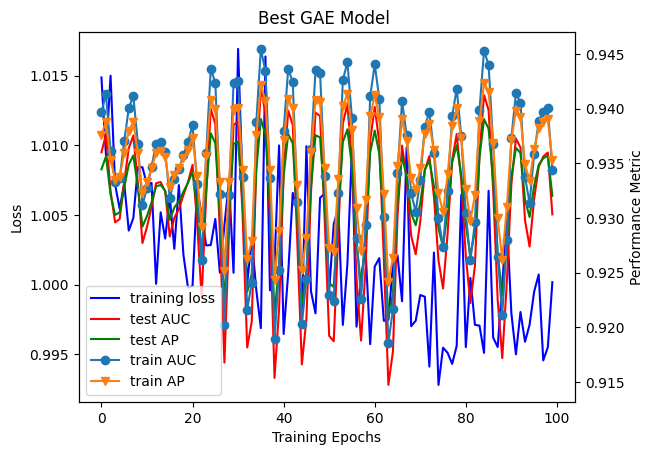

Best Threshold=0.599132


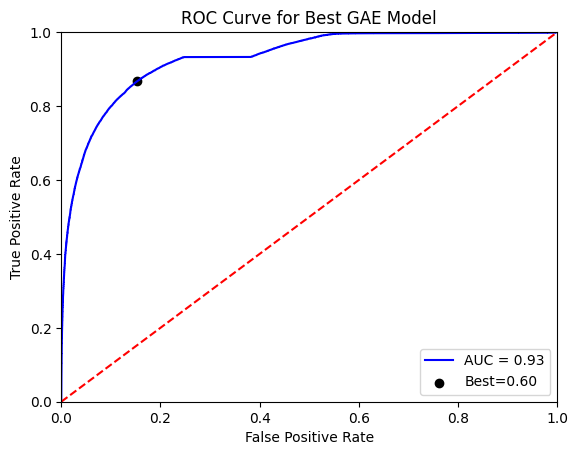

In [45]:
plot_training_stats('Best GAE Model ', losses, test_auc, test_ap, train_aucs, train_aps)
plot_roc_curve('ROC Curve for Best GAE Model',gae_model, test_set)

>##### Getting the predictions and visualizing what the look like.

In [ ]:
gae_ranked_edge_list, gae_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)

>##### Here we can see a 2D array which just means each row has 2 values/columns. The first column is the node number for the disease node. The second column is the gene node number for the gene. These two nodes are connected.

In [ ]:
gae_ranked_edge_list

array([[  18, 6956],
       [ 852, 6956],
       [  32, 6956],
       ...,
       [3324, 8511],
       [2821, 8511],
       [4114, 8511]])

> ##### Here we can see a 1 D array that contains the dot product/similarity score value. So the 8.478 (first value) is the score for nodes 18 and 6956. *** This is verified further down.

In [ ]:
gae_ranked_dot_products

array([8.4378452e+00, 8.4099836e+00, 8.2084608e+00, ..., 1.4379130e-04,
       1.4151233e-04, 1.4019468e-04], dtype=float32)

>#### This function helps create a better visual output of the ranked and dot product prediction results.

In [46]:
# Create reverse mappings for indices back to names
disease_name_mapping = {index: mondo_id for mondo_id, index in disease_mappings.items()}
gene_name_mapping = {index: gene_id for gene_id, index in gene_mappings.items()}

# Function to format the results using the reverse mappings, including MONDO ID and gene symbol
def format_ga_results(ranked_edge_list, ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features):
    # Convert MONDO IDs and gene IDs to names for display
    mondo_to_name = dict(zip(disgenet_with_features['mondo_id'], disgenet_with_features['mondo_term']))
    
    # Ensure gene_to_symbol uses consistent types for keys (convert to str)
    gene_to_symbol = {str(k): v for k, v in zip(disgenet_with_features['gene_id'], disgenet_with_features['gene_name'])}
    
    formatted_results = []

    for idx in range(len(ranked_dot_products)):
        disease_idx, gene_idx = ranked_edge_list[idx]
        
        # Retrieve the MONDO ID and gene ID using index mappings
        mondo_id = disease_name_mapping.get(disease_idx, f"Unknown Disease ({disease_idx})")
        gene_id = gene_name_mapping.get(gene_idx, f"Unknown Gene ({gene_idx})")
        
        # Use the MONDO ID and gene ID to get the actual names and symbols
        disease_name = mondo_to_name.get(mondo_id, mondo_id)
        gene_symbol = gene_to_symbol.get(str(gene_id), f"Unknown Gene ({gene_id})")  # Convert gene_id to str
        
        # Format each result to include MONDO ID and gene symbol
        edge_description = f"({mondo_id}-{disease_name}, {gene_id}({gene_symbol}))"
        formatted_results.append((ranked_dot_products[idx], edge_description))

    # Convert to DataFrame for easy viewing and manipulation
    results_df = pd.DataFrame(formatted_results, columns=["Dotprod", "Edges(Disease, Gene)"])
    return results_df

# Generate the formatted DataFrame
formatted_df = format_ga_results(gae_ranked_edge_list, gae_ranked_dot_products, disease_name_mapping, gene_name_mapping, disgenet_with_features)

# Display the DataFrame to check the output format
print(formatted_df.head(15))


NameError: name 'gae_ranked_edge_list' is not defined

>##### Coming back to this we can see that disease node 18 is MONDO:0004989 and gene node 6956 has entrez gene id 51742. As seen in the dataframe above we have the same data above.

In [ ]:
gae_ranked_edge_list

array([[  18, 6956],
       [ 852, 6956],
       [  32, 6956],
       ...,
       [3324, 8511],
       [2821, 8511],
       [4114, 8511]])

In [ ]:
gae_ranked_dot_products

array([8.4378452e+00, 8.4099836e+00, 8.2084608e+00, ..., 1.4379130e-04,
       1.4151233e-04, 1.4019468e-04], dtype=float32)

In [ ]:
print(gene_name_mapping)
#print(gene_mappings)
print(disease_mappings)

{0: 2, 1: 9, 2: 10, 3: 12, 4: 15, 5: 16, 6: 18, 7: 19, 8: 20, 9: 21, 10: 22, 11: 23, 12: 24, 13: 25, 14: 26, 15: 27, 16: 28, 17: 29, 18: 31, 19: 32, 20: 33, 21: 34, 22: 35, 23: 36, 24: 37, 25: 38, 26: 39, 27: 40, 28: 41, 29: 43, 30: 47, 31: 48, 32: 49, 33: 50, 34: 51, 35: 53, 36: 54, 37: 55, 38: 58, 39: 59, 40: 60, 41: 70, 42: 71, 43: 72, 44: 81, 45: 86, 46: 87, 47: 88, 48: 90, 49: 91, 50: 92, 51: 93, 52: 94, 53: 95, 54: 100, 55: 102, 56: 103, 57: 104, 58: 105, 59: 107, 60: 108, 61: 109, 62: 111, 63: 112, 64: 113, 65: 114, 66: 115, 67: 116, 68: 117, 69: 118, 70: 119, 71: 120, 72: 123, 73: 125, 74: 126, 75: 127, 76: 128, 77: 131, 78: 132, 79: 133, 80: 134, 81: 135, 82: 140, 83: 142, 84: 143, 85: 146, 86: 147, 87: 148, 88: 150, 89: 151, 90: 152, 91: 153, 92: 154, 93: 155, 94: 156, 95: 157, 96: 158, 97: 161, 98: 162, 99: 163, 100: 165, 101: 166, 102: 172, 103: 173, 104: 174, 105: 175, 106: 176, 107: 177, 108: 178, 109: 181, 110: 182, 111: 183, 112: 185, 113: 186, 114: 187, 115: 189, 116: 

#### Since my main focus was to look at predicting new connections between TB and genes, I filtered out the predictions for TB. As seen below we have 11557 predictions which is a lot more than 106 genes BUT the dotproducts are low. Regardless it gives us more gene candidates that need to be further evaluated.

In [223]:
# filter out tb dot product results only
# Filter the DataFrame for a specific MONDO ID
specific_mondo_id = "MONDO:0018076-tuberculosis"

# Check if the MONDO ID is in the 'Edges(Disease, Gene)' column
tb_dotprod_results = formatted_df[formatted_df["Edges(Disease, Gene)"].str.contains(specific_mondo_id, regex=False)]

# Display the filtered DataFrame
tb_dotprod_results


,Dotprod,"Edges(Disease, Gene)"
102233,2.006077,"(MONDO:0018076-tuberculosis, 51742(ARID4B))"
163319,1.865512,"(MONDO:0018076-tuberculosis, 29127(RACGAP1))"
173022,1.848132,"(MONDO:0018076-tuberculosis, 50944(SHANK1))"
174230,1.841521,"(MONDO:0018076-tuberculosis, 347689(SOX2-OT))"
195679,1.765663,"(MONDO:0018076-tuberculosis, 79730(NSUN7))"
...,...,...
73958118,0.036081,"(MONDO:0018076-tuberculosis, 85417(CCNB3))"
74350835,0.032791,"(MONDO:0018076-tuberculosis, 103157000(PAUPAR))"
74538519,0.030918,"(MONDO:0018076-tuberculosis, 131566(DCBLD2))"
75758643,0.015143,"(MONDO:0018076-tuberculosis, 64747(MFSD1))"


##### Visually inspect the range of the dot product results for the TB gene predictions.

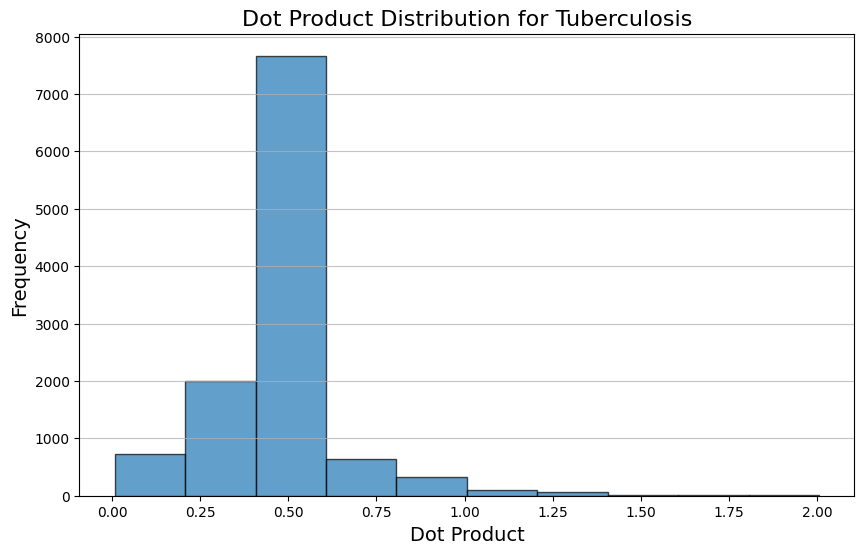

In [ ]:
# Plotting the dot product distribution for tuberculosis results
plt.figure(figsize=(10, 6))
plt.hist(tb_dotprod_results['Dotprod'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Dot Product Distribution for Tuberculosis', fontsize=16)
plt.xlabel('Dot Product', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


# Get drug data


In [157]:
dgidb_data = pd.read_csv('../data/processed/dgidb_final_drugdata.tsv', delimiter= '\t')
dgidb_data

,entrezgene,mygene_symbol,chembl_drugid,drug_name,interaction_score,approved
0,9236,CCPG1,CHEMBL1833984,CHEMBL:CHEMBL1833984,0.840123,False
1,6204,RPS10,CHEMBL119405,BENZENETHIOL,0.570736,False
2,336,APOA2,CHEMBL347610,CHEMBL:CHEMBL347610,0.889961,False
3,10330,CNPY2,CHEMBL4297789,MT-3724,0.129649,False
4,9183,ZW10,CHEMBL490510,MAREIN,0.201179,False
...,...,...,...,...,...,...
28602,8260,NAA10,CHEMBL56985,LY341495,0.182954,False
28603,8260,NAA10,CHEMBL144151,LY341495,0.182954,False
28604,8260,NAA10,CHEMBL123376,LY341495,0.182954,False
28605,8260,NAA10,CHEMBL1597105,LY341495,0.182954,False


In [158]:
# we need to filter out the genes that are only in the final GAE results of the gene predictions
unique_genes = np.unique(gae_ranked_edge_list[:, 1])
unique_genes

array([ 6584,  6585,  6586, ..., 18138, 18139, 18140])

In [159]:
filtered_dgidb_df = dgidb_data[dgidb_data['entrezgene'].isin(unique_genes)]

print("Filtered DataFrame:")
filtered_dgidb_df

Filtered DataFrame:


,entrezgene,mygene_symbol,chembl_drugid,drug_name,interaction_score,approved
0,9236,CCPG1,CHEMBL1833984,CHEMBL:CHEMBL1833984,0.840123,False
3,10330,CNPY2,CHEMBL4297789,MT-3724,0.129649,False
4,9183,ZW10,CHEMBL490510,MAREIN,0.201179,False
5,7291,TWIST1,CHEMBL1782601,THEONELLASTEROL E,0.760981,False
6,6769,STAC,CHEMBL601367,CHEMBL:CHEMBL601367,0.076430,False
...,...,...,...,...,...,...
28602,8260,NAA10,CHEMBL56985,LY341495,0.182954,False
28603,8260,NAA10,CHEMBL144151,LY341495,0.182954,False
28604,8260,NAA10,CHEMBL123376,LY341495,0.182954,False
28605,8260,NAA10,CHEMBL1597105,LY341495,0.182954,False


In [160]:
# scale the interaction scores
# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_dgidb_df['standardized_interaction_scores'] = scale.fit_transform(filtered_dgidb_df['interaction_score'].values.reshape(-1, 1))
# drop confidence values column and only keep the standardized values
filtered_dgidb_df.drop(columns='interaction_score', inplace=True)

filtered_dgidb_df.head(20)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/615898709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dgidb_df['standardized_interaction_scores'] = scale.fit_transform(filtered_dgidb_df['interaction_score'].values.reshape(-1, 1))
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/615898709.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dgidb_df.drop(columns='interaction_score', inplace=True)


,entrezgene,mygene_symbol,chembl_drugid,drug_name,approved,standardized_interaction_scores
0,9236,CCPG1,CHEMBL1833984,CHEMBL:CHEMBL1833984,False,-0.046170
3,10330,CNPY2,CHEMBL4297789,MT-3724,False,-0.181706
4,9183,ZW10,CHEMBL490510,MAREIN,False,-0.168060
5,7291,TWIST1,CHEMBL1782601,THEONELLASTEROL E,False,-0.061268
6,6769,STAC,CHEMBL601367,CHEMBL:CHEMBL601367,False,-0.191858
9,9824,ARHGAP11A,CHEMBL1415258,CHEMBL:CHEMBL1415258,False,-0.177982
10,9235,IL32,CHEMBL3544958,CER-002,False,0.094817
15,11118,BTN3A2,CHEMBL1351571,4-BENZYLOXYANILINE,False,-0.180353
16,6893,TAPVR1,CHEMBL1371413,"2,3-DIHYDROXY-4-METHOXY-4'-ETHOXYBENZOPHENONE",False,-0.198867
18,9183,ZW10,CHEMBL1371413,"2,3-DIHYDROXY-4-METHOXY-4'-ETHOXYBENZOPHENONE",False,-0.193646


In [183]:
# construct the pytroch data object to train models
def drug_node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

def drug_edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

def get_drugdata_with_features(disgenet_with_features, num_features):
    gene_col, drug_col = "entrezgene", "chembl_drugid"
    
    # get the node index mappings
    map_gene_nodes = drug_node_mapping(disgenet_with_features, gene_col)
    map_drug_nodes = drug_node_mapping(disgenet_with_features, drug_col)
    
    # get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, drug_col, map_drug_nodes)
    
    # add the reverse index to make it an undirected graph
    reverse_edge_index = drug_edge_list(disgenet_with_features, drug_col, map_drug_nodes, gene_col, map_gene_nodes)
    
    # initialize the data object
    data = Data()
    data.num_nodes = len(map_gene_nodes) + len(map_drug_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # initialize disease features as ones
    dis_features = torch.ones((len(map_gene_nodes), num_features), dtype=torch.float32)
    
    # initialize gene features using the merged df
    gene_features_values = disgenet_with_features.drop_duplicates(subset='chembl_drugid').set_index('chembl_drugid')[['standardized_interaction_scores']].reindex(map_drug_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_drug_nodes, map_gene_nodes

In [184]:
# create new gae with the drug data
num_features = 1
dgidb_torch_data,drug_map, gene_map,  = get_drugdata_with_features(filtered_dgidb_df, num_features)

In [185]:
print(dgidb_torch_data)
for key, value in dgidb_torch_data:
    print(f"{key}: {value}")

Data(num_nodes=3783, edge_index=[2, 13390], x=[3783, 1])
num_nodes: 3783
edge_index: tensor([[   0,    1,    2,  ..., 2315, 2316, 3258],
        [   0,    1,    2,  ...,  157,  157,  157]])
x: tensor([[1.0000],
        [1.0000],
        [1.0000],
        ...,
        [0.0379],
        [0.0379],
        [0.0379]])


In [196]:
def visualize_disease_gene_subgraph(
    torch_data, disease_mappings, gene_mappings, disgenet_raw,column1, column2, node_color1, node_color2, legend_label1, legend_label2,
    gene_limit_per_disease=3, num_disease_nodes=10, 
):

    # Convert the PyTorch Geometric Data to a NetworkX graph
    G = to_networkx(torch_data, to_undirected=True)

    # Filter out disease-to-disease edges
    disease_nodes = set(disease_mappings.values())
    disease_to_disease_edges = [(u, v) for u, v in G.edges() if u in disease_nodes and v in disease_nodes]
    G.remove_edges_from(disease_to_disease_edges)

    # Select the first `num_disease_nodes` disease nodes
    disease_node_indices = list(disease_mappings.values())[:num_disease_nodes]

    # Limit the number of gene nodes to display per disease node
    connected_gene_nodes = set()
    for disease_node in disease_node_indices:
        neighbors = list(G.neighbors(disease_node))
        gene_neighbors = [n for n in neighbors if n in gene_mappings.values()]
        sampled_genes = random.sample(gene_neighbors, min(gene_limit_per_disease, len(gene_neighbors)))
        connected_gene_nodes.update(sampled_genes)

    # Create a subgraph with the selected disease and limited gene nodes
    subgraph = G.subgraph(disease_node_indices + list(connected_gene_nodes))

    # Create a dictionary for MONDO ID to disease name mapping
    mondo_to_name = dict(zip(disgenet_raw[column1], disgenet_raw[column2]))

    # Create a dictionary to label nodes with MONDO IDs, disease names, and Entrez Gene IDs
    labels = {}
    for disease_id, node in disease_mappings.items():
        if node in disease_node_indices:
            disease_name = mondo_to_name.get(disease_id, "Unknown Disease")
            labels[node] = f"{disease_id}\n{disease_name}"

    for gene_id, node in gene_mappings.items():
        if node in connected_gene_nodes:
            labels[node] = gene_id  # Use Entrez Gene ID for gene nodes

    # Set fixed positions for a bipartite layout
    pos = {}
    # Disease nodes on the left
    for i, node in enumerate(disease_node_indices):
        pos[node] = (-1, i * (2 / len(disease_node_indices)) - 1)

    # Gene nodes on the right
    for i, node in enumerate(connected_gene_nodes):
        pos[node] = (1, i * (2 / len(connected_gene_nodes)) - 1)

    # Plotting
    plt.figure(figsize=(18, 10))

    # Draw disease and gene nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=disease_node_indices, node_color=node_color1, label=legend_label1, node_size=500)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(connected_gene_nodes), node_color=node_color2, label=legend_label2, node_size=500)

    # Color each disease's edges uniquely
    colors = plt.cm.tab20.colors
    for idx, disease_node in enumerate(disease_node_indices):
        disease_edges = [(disease_node, neighbor) for neighbor in subgraph.neighbors(disease_node)]
        nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)

    # Add labels with MONDO IDs, disease names, and Entrez IDs
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

    # Add legend and display
    plt.legend(scatterpoints=1)
    plt.axis("off")
    plt.show()


In [187]:
print(gene_map)
print(drug_map)

{9236: 0, 10330: 1, 9183: 2, 7291: 3, 6769: 4, 9824: 5, 9235: 6, 11118: 7, 6893: 8, 10344: 9, 6833: 10, 10383: 11, 6873: 12, 7782: 13, 8506: 14, 7508: 15, 9804: 16, 6834: 17, 8517: 18, 9792: 19, 7105: 20, 9181: 21, 8780: 22, 10477: 23, 11117: 24, 6973: 25, 9182: 26, 7276: 27, 7223: 28, 10471: 29, 9826: 30, 10432: 31, 10000: 32, 9402: 33, 9412: 34, 10505: 35, 8153: 36, 9948: 37, 10588: 38, 10962: 39, 7216: 40, 6871: 41, 9542: 42, 7010: 43, 9077: 44, 10555: 45, 6636: 46, 7978: 47, 7059: 48, 9406: 49, 6768: 50, 9611: 51, 6876: 52, 6875: 53, 7974: 54, 7019: 55, 9583: 56, 9486: 57, 9955: 58, 8031: 59, 11049: 60, 8781: 61, 7965: 62, 8583: 63, 7979: 64, 8893: 65, 10178: 66, 10360: 67, 10298: 68, 7043: 69, 9652: 70, 6932: 71, 7177: 72, 9801: 73, 11330: 74, 6877: 75, 10260: 76, 9967: 77, 9232: 78, 11332: 79, 7795: 80, 9659: 81, 9021: 82, 9865: 83, 11136: 84, 9545: 85, 7091: 86, 9399: 87, 8816: 88, 10637: 89, 7515: 90, 11331: 91, 7315: 92, 6727: 93, 11138: 94, 9410: 95, 11281: 96, 7132: 97, 7381

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_83432/3688558473.py:63: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos, edgelist=disease_edges, edge_color=[colors[idx % len(colors)]], width=2)


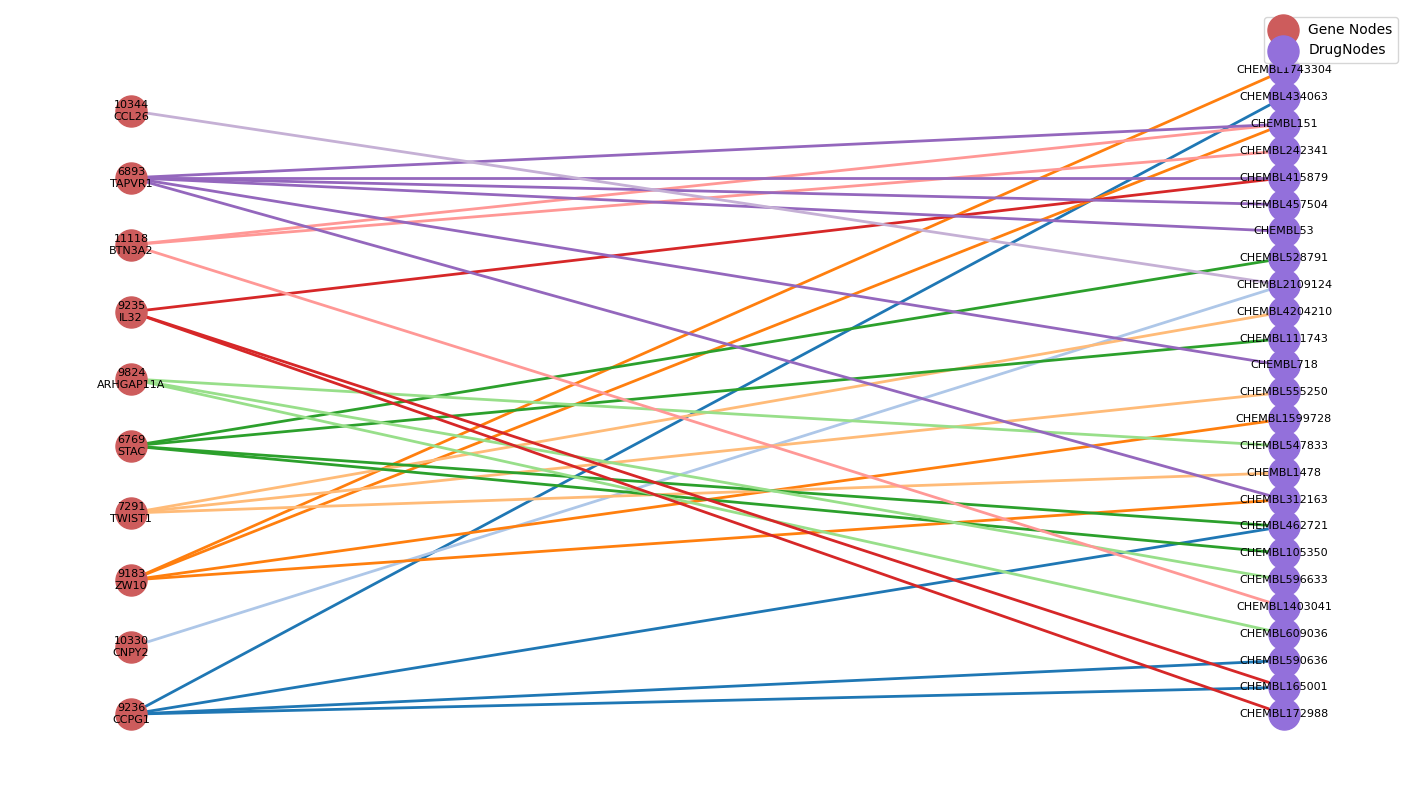

In [197]:
# visualize_disease_gene_subgraph(
#     torch_data, disease_mappings, gene_mappings, disgenet_raw,column1, column2, node_color1, node_color2, legend_label1, legend_label2,
# )

visualize_disease_gene_subgraph(dgidb_torch_data, gene_map, drug_map, 
                                dgidb_data, "entrezgene", "mygene_symbol",
                                "crimson", "mediumpurple", "Gene Nodes", "DrugNodes")

In [224]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

drug_train_set, drug_val_set, drug_test_set = transform(dgidb_torch_data)
print("Training set: \n", drug_train_set)
print("Validation set: \n", drug_val_set)
print("Test set: \n", drug_test_set)

cpu
Training set: 
 Data(num_nodes=3783, edge_index=[2, 10732], x=[3783, 1], pos_edge_label=[5366], pos_edge_label_index=[2, 5366], neg_edge_label=[5366], neg_edge_label_index=[2, 5366])
Validation set: 
 Data(num_nodes=3783, edge_index=[2, 10732], x=[3783, 1], pos_edge_label=[335], pos_edge_label_index=[2, 335], neg_edge_label=[335], neg_edge_label_index=[2, 335])
Test set: 
 Data(num_nodes=3783, edge_index=[2, 11402], x=[3783, 1], pos_edge_label=[1006], pos_edge_label_index=[2, 1006], neg_edge_label=[1006], neg_edge_label_index=[2, 1006])


In [228]:
# define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

# initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 5
output_dim = 1
learning_rate = 1
epochs = 100

drug_encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
drug_gae_model = GAE(drug_encoder)
drug_gae_model = drug_gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.Adadelta(drug_gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

drug_gae_model.apply(weights_init)

drug_losses = []
drug_test_auc = []
drug_test_ap = []
drug_train_aucs = []
drug_train_aps = []

writer = SummaryWriter(log_dir="../data/processed/runs/gae_experiment/drug_adadelta")

for epoch in range(1, epochs + 1):
    drug_loss = gae_train(drug_train_set, drug_gae_model, optimizer)
    drug_losses.append(loss)
    
    drug_train_auc, drug_train_ap = gae_test(drug_train_set, drug_gae_model)
    drug_train_aucs.append(drug_train_auc)
    drug_train_aps.append(drug_train_ap)
    
    drug_test_auc_value, drug_test_ap_value = gae_test(drug_test_set, drug_gae_model)
    drug_test_auc.append(drug_test_auc_value)
    drug_test_ap.append(drug_test_ap_value)
    
        # Log the metrics to TensorBoard
    writer.add_scalar("Loss/train", drug_loss, epoch)
    writer.add_scalar("AUC/train", drug_train_auc, epoch)
    writer.add_scalar("AP/train", drug_train_ap, epoch)
    writer.add_scalar("AUC/test", drug_test_auc_value, epoch)
    writer.add_scalar("AP/test", drug_test_ap_value, epoch)

    print(f'Epoch: {epoch:03d}, Loss: {drug_loss:.4f}, Train AUC: {drug_train_auc:.4f}, Train AP: {drug_train_ap:.4f}, Test AUC: {drug_test_auc_value:.4f}, Test AP: {drug_test_ap_value:.4f}')
writer.close()

Epoch: 001, Loss: 1.3701, Train AUC: 0.9419, Train AP: 0.9253, Test AUC: 0.8122, Test AP: 0.8392
Epoch: 002, Loss: 1.3683, Train AUC: 0.9441, Train AP: 0.9279, Test AUC: 0.8287, Test AP: 0.8477
Epoch: 003, Loss: 1.3644, Train AUC: 0.9460, Train AP: 0.9302, Test AUC: 0.8423, Test AP: 0.8554
Epoch: 004, Loss: 1.3612, Train AUC: 0.9476, Train AP: 0.9323, Test AUC: 0.8536, Test AP: 0.8621
Epoch: 005, Loss: 1.3594, Train AUC: 0.9490, Train AP: 0.9340, Test AUC: 0.8626, Test AP: 0.8679
Epoch: 006, Loss: 1.3560, Train AUC: 0.9503, Train AP: 0.9357, Test AUC: 0.8706, Test AP: 0.8732
Epoch: 007, Loss: 1.3622, Train AUC: 0.9513, Train AP: 0.9370, Test AUC: 0.8767, Test AP: 0.8774
Epoch: 008, Loss: 1.3498, Train AUC: 0.9524, Train AP: 0.9383, Test AUC: 0.8827, Test AP: 0.8816
Epoch: 009, Loss: 1.3520, Train AUC: 0.9533, Train AP: 0.9395, Test AUC: 0.8875, Test AP: 0.8851
Epoch: 010, Loss: 1.3362, Train AUC: 0.9542, Train AP: 0.9408, Test AUC: 0.8921, Test AP: 0.8885
Epoch: 011, Loss: 1.3357, Trai

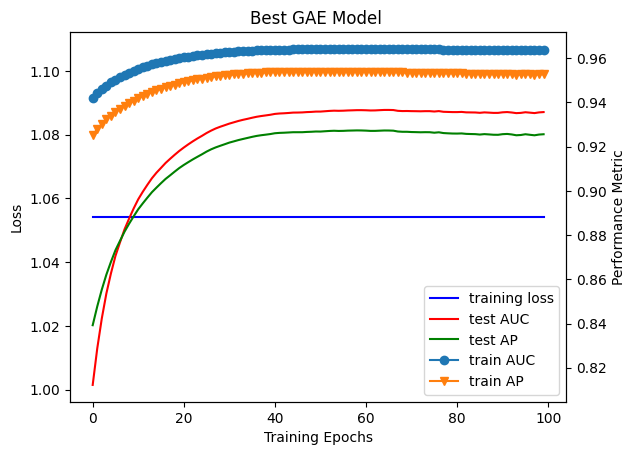

Best Threshold=0.605963


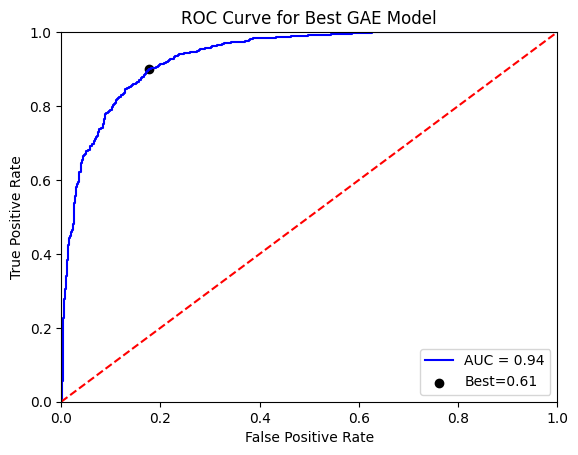

In [229]:
plot_training_stats('Best GAE Model ', drug_losses, drug_test_auc, drug_test_ap, drug_train_aucs, drug_train_aps)
plot_roc_curve('ROC Curve for Best GAE Model',drug_gae_model, drug_test_set)